In [ ]:
# https://medium.com/@gpj/predict-next-number-using-pytorch-47187c1b8e33

import torch
import torch.nn as nn

# Define the model
class NextNumberPredictor(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(NextNumberPredictor, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size)
    self.fc = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    x, _ = self.lstm(x)
    x = self.fc(x)
    return x

  # Train the model
  def train(model, data, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
      for input_sequence, target in data:
        input_sequence = torch.Tensor(input_sequence).view(len(input_sequence), 1, -1)
        target = torch.Tensor(target).view(len(target), -1)
      
        # Forward pass
        output = model(input_sequence)
        loss = loss_fn(output, target)
      
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Test the model
  def test(model, data, loss_fn):
    total_loss = 0
    for input_sequence, target in data:
      input_sequence = torch.Tensor(input_sequence).view(len(input_sequence), 1, -1)
      target = torch.Tensor(target).view(len(target), -1)
      output = model(input_sequence)
      total_loss += loss_fn(output, target).item()
    return total_loss / len(data)

# Setup the model, data, loss function and optimizer
model = NextNumberPredictor(1, 32, 1)
data = [(list(range(10)), list(range(1, 11))), (list(range(10, 20)), list(range(11, 21)))]
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
model.train(data, loss_fn, optimizer, num_epochs=100)

# Use the model to make predictions
input_sequence = torch.Tensor(list(range(10, 20))).view(10, 1, -1)
output = model(input_sequence)
prediction = output[-1].item()
print(f'Predicted next number: {prediction:.4f}')

/srv/conda/envs/notebook/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [4]:
# https://medium.com/@gpj/predict-next-number-using-pytorch-47187c1b8e33

# https://github.com/pytorch/examples/tree/main/time_sequence_prediction

In [5]:
import numpy as np
import torch
import json

In [23]:
import numpy as np
import torch

np.random.seed(2)

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

(100, 1000)

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--steps', type=int, default=15, help='steps to run')
#    opt = parser.parse_args()
    STEPS = 10
    # set random seed to 0
    np.random.seed(0)
    torch.manual_seed(0)
    # load data and make training set
    data = torch.load('traindata.pt')
    input = torch.from_numpy(data[3:, :-1])
    target = torch.from_numpy(data[3:, 1:])
    test_input = torch.from_numpy(data[:3, :-1])
    test_target = torch.from_numpy(data[:3, 1:])
    # build the model
    seq = Sequence()
    seq.double()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
    #begin to train
#    for i in range(opt.steps):
    for i in range(STEPS):
        print('STEP: ', i)
        def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        # begin to predict, no need to track gradient here
        with torch.no_grad():
            future = 1000
            pred = seq(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print('test loss:', loss.item())
            y = pred.detach().numpy()
        # draw the result
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
            plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        plt.savefig('predict%d.pdf'%i)
        plt.close()

STEP:  0
loss: 0.5023738122475573
loss: 0.49856639379435636
loss: 0.479011960611529
loss: 0.4463349021484229
loss: 0.35406310257492946
loss: 0.205070166176814
loss: 1.3960531561167868
loss: 0.03249441148471836
loss: 0.0299348758396043
loss: 0.028326821011534196
loss: 0.026830612218823213
loss: 0.023771201989989825
loss: 0.01890141350454591
loss: 0.010646818233205837
loss: 0.008725752090268492
loss: 0.007872181287777192
loss: 0.00547784274959428
loss: 0.004051933564063729
loss: 0.0027296227011592606
loss: 0.001540265276981073
test loss: 0.0013000876156956857
STEP:  1
loss: 0.0012797646167828115
loss: 0.0011690554954718023
loss: 0.0011498916013728743
loss: 0.0011288245291281654
loss: 0.001063056134102438
loss: 0.0009564006443280232
loss: 0.0008210827589980865
loss: 0.0007670796029147313
loss: 0.0007294716423579147
loss: 0.0007246558169812476
loss: 0.0007206211393649988
loss: 0.0007126686053108176
loss: 0.0006961310498771502
loss: 0.0006641101811544719
loss: 0.0006101210702280004
loss: 0.

In [9]:
import openpyxl
import json

In [23]:
# globale Parameter; Datei, Zeilen und Spalten mit Informationen

# Excel Datei
filename = "/media/sf_Dokumente/_TODO_OFFEN/Experte BMS Chur/daten_anonym.xlsx"

# Spalten mit Aufgaben
ci = openpyxl.utils.cell.column_index_from_string
spalten = list(range(ci('A'), ci('G')+1))

In [24]:
# Parameter; Datei, Zeilen und Spalten mit Informationen

# Excel Datei
sheet_01 = openpyxl.load_workbook(filename, data_only=True).active
#sheet_01 = openpyxl.load_workbook(filename, data_only=True)['TBM7 4A']

# Zeilen mit SuS
zeilen_01 = list(range(4, 215+1))

# Spalten mit Aufgaben
spalten_01 = spalten

In [31]:
# Daten aus Excel Tabelle einlesen
namen_01 = []
punkte_01 = []
noten_01 = []
pnoten_01 = []
enoten_01 = []
fnoten_01 = []
for z in zeilen_01:
    p = []
    for s in spalten_01:
        p.append( sheet_01.cell(z, s).value )
    noten_01.append( p )

np.array( noten_01 ).shape

(212, 7)

In [33]:
json.dumps(noten_01)

'[[5.5, 4.5, 5, 5, null, 5, 5.5], [3, 3, 4, 4, null, 3.5, 3.5], [5.5, 6, 6, 5.5, null, 6, 6], [4.5, 4, 4.5, 5, null, 4.5, 4.5], [2.5, 3, 4, 2.5, null, 3, 3], [2.5, 3, 3.5, 3, null, 3, 3], [3.5, 4, 4, 4.5, null, 4, 4], [4.5, 4, 4, 4.5, null, 4, 4.5], [4, 4.5, 4.5, 4, null, 4.5, 4.5], [3, 3, 3.5, 3.5, null, 3.5, 3.5], [5.5, 6, 6, 6, null, 6, 6], [4, 4.5, 5, 5, null, 5, 4.5], [5, 3.5, 4, 4.5, null, 4, 4.5], [4, 3.5, 4.5, 4, null, 4, 4], [4, 4, 4, 3.5, 4, 4, 4], [4.5, 4.5, 5.5, 4.5, 4.5, 5, 5], [1.5, 2.5, 3.5, 3, 2, 3, 2.5], [null, 3, 3.5, 2.5, 2.5, 3, 3], [4.5, 5, 5, 5, 5, 5, 5], [3.5, 4.5, 4.5, 4, 4.5, 4.5, 4], [4, 5.5, 5.5, 4.5, 5.5, 5.5, 5], [4.5, 4, 4, 3.5, 3.5, 4, 4.5], [2.5, 4, 4, 4, 4, 4, 3.5], [5, 5, 5, 5, 4.5, 5, 5], [6, 5.5, 5.5, 4.5, 6, 5.5, 6], [4.5, 4.5, 4.5, 3, 5, 4.5, 4.5], [4, 5, 5, 4, 5, 5, 4.5], [4, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5], [3, 4, 4, 2.5, 3, 3.5, 3.5], [2, 3.5, 3.5, 2.5, 2.5, 3, 2.5], [3, 4, 4, 3.5, 3.5, 4, 3.5], [2, 4.5, 4.5, 3, 4, 4, 3], [2.5, 3.5, 3.5, 3.5, 3.5,

In [6]:
data = json.loads('[[5.5, 4.5, 5, 5, null, 5, 5.5], [3, 3, 4, 4, null, 3.5, 3.5], [5.5, 6, 6, 5.5, null, 6, 6], [4.5, 4, 4.5, 5, null, 4.5, 4.5], [2.5, 3, 4, 2.5, null, 3, 3], [2.5, 3, 3.5, 3, null, 3, 3], [3.5, 4, 4, 4.5, null, 4, 4], [4.5, 4, 4, 4.5, null, 4, 4.5], [4, 4.5, 4.5, 4, null, 4.5, 4.5], [3, 3, 3.5, 3.5, null, 3.5, 3.5], [5.5, 6, 6, 6, null, 6, 6], [4, 4.5, 5, 5, null, 5, 4.5], [5, 3.5, 4, 4.5, null, 4, 4.5], [4, 3.5, 4.5, 4, null, 4, 4], [4, 4, 4, 3.5, 4, 4, 4], [4.5, 4.5, 5.5, 4.5, 4.5, 5, 5], [1.5, 2.5, 3.5, 3, 2, 3, 2.5], [null, 3, 3.5, 2.5, 2.5, 3, 3], [4.5, 5, 5, 5, 5, 5, 5], [3.5, 4.5, 4.5, 4, 4.5, 4.5, 4], [4, 5.5, 5.5, 4.5, 5.5, 5.5, 5], [4.5, 4, 4, 3.5, 3.5, 4, 4.5], [2.5, 4, 4, 4, 4, 4, 3.5], [5, 5, 5, 5, 4.5, 5, 5], [6, 5.5, 5.5, 4.5, 6, 5.5, 6], [4.5, 4.5, 4.5, 3, 5, 4.5, 4.5], [4, 5, 5, 4, 5, 5, 4.5], [4, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5], [3, 4, 4, 2.5, 3, 3.5, 3.5], [2, 3.5, 3.5, 2.5, 2.5, 3, 2.5], [3, 4, 4, 3.5, 3.5, 4, 3.5], [2, 4.5, 4.5, 3, 4, 4, 3], [2.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3], [4, 4, 4.5, 3.5, 3.5, 4, 4], [4, 4.5, 4.5, 4, 5.5, 4.5, 4.5], [4, 5.5, 5.5, 5.5, 4.5, 5.5, 5], [3.5, 4, 4, 4, 4, 4, 4], [3.5, 4, 4.5, 4.5, 4, 4.5, 4], [3, 3.5, 4, 3.5, 3.5, 3.5, 3.5], [2.5, 4, 3, null, null, 3.5, 3], [3.5, 4.5, 4.5, null, null, 4.5, 4], [2.5, 5, 3, null, null, 4, 3.5], [5, 5.5, 5, null, null, 5.5, 5.5], [3.5, 4.5, 4.5, null, null, 4.5, 4], [2, 3.5, 3, null, null, 3.5, 3], [3.5, 4.5, 4.5, null, null, 4.5, 4], [4, 5, 4.5, null, null, 5, 4.5], [3.5, 4.5, 3.5, null, null, 4, 4], [4.5, 4.5, 4.5, null, null, 4.5, 4.5], [4, 4.5, 4.5, null, null, 4.5, 4.5], [3.5, 4, 3.5, null, null, 4, 4], [4, 5, 5, null, null, 5, 4.5], [4, 5.5, 5.5, null, null, 5.5, 5], [4, 3.5, 4, null, null, 4, 4], [3.5, 4, 4, null, null, 4, 4], [4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5], [5.5, 5, 5, 5.5, 4.5, 5, 5.5], [5.5, 5.5, 4.5, 5, 4.5, 5, 5.5], [4.5, 4, 4.5, 3.5, 4, 4, 4.5], [5.5, 5, 5, 5.5, 5, 5, 5.5], [6, 5, 5.5, 5, 4.5, 5, 5.5], [5, 5.5, 5.5, 5.5, 5, 5.5, 5.5], [5, 4.5, 5, 5, 4.5, 5, 5], [4, 4.5, 5, 4.5, 4, 4.5, 4.5], [4, 4, 4, 3.5, 3.5, 4, 4], [3, 4.5, 4, 4, 4, 4, 3.5], [4.5, 5, 5.5, 4.5, 3.5, 4.5, 4.5], [6, 5.5, 5, 5.5, 5, 5.5, 6], [6, 5.5, 5, 5.5, 5, 5.5, 6], [4, 4, 3, 3, 3, 3.5, 4], [4, 4, 4, 4.5, 3.5, 4, 4], [5, 4, 4, 4.5, 4.5, 4.5, 5], [4, 4.5, 4.5, 4, 3.5, 4, 4], [4, 4.5, 3.5, 3.5, 3.5, 4, 4], [4.5, 4, 4, 3.5, 4.5, 4, 4.5], [5, 4, 3, 4.5, 4, 4, 4.5], [3.5, 4.5, 4.5, 4, 3.5, 4, 4], [3, 4.5, 4.5, 4.5, 3.5, 4.5, 4], [4, 3.5, 4, 3.5, 4, 4, 4], [3.5, 4, 4, 4, 4, 4, 4], [3.5, 5, 4, 4, 4, 4.5, 4], [4, 4.5, 4, 4.5, 4, 4.5, 4.5], [4, 5, 4.5, 5.5, 4, 5, 4.5], [4, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5], [3.5, 4.5, 3.5, 4, 4, 4, 4], [4, 4.5, 4, 4, 4.5, 4.5, 4.5], [3.5, 4.5, 4, 4.5, 4, 4.5, 4], [3.5, 4, 3.5, 3, 3.5, 3.5, 3.5], [3, 3, 3.5, 3, 4, 3.5, 3.5], [4.5, 5, 5.5, 5.5, 6, 5.5, 5], [5, 4, 4.5, 5.5, 3.5, 4.5, 5], [3.5, 3.5, 3.5, 4, 3.5, 3.5, 3.5], [5, 5, 5.5, 4.5, 4, 5, 5], [4.5, 4.5, 4, 4.5, 4, 4.5, 4.5], [5, 4.5, 5, 4.5, 4.5, 4.5, 5], [4.5, 5, 4.5, 4.5, 5, 5, 5], [3, 4, 3.5, 3.5, 3, 3.5, 3.5], [4, 4.5, 3.5, 3.5, 3.5, 4, 4], [1.5, 2.5, 2.5, 2, 1.5, 2, 2], [3.5, 5, 4.5, 4.5, 5, 5, 4.5], [5, 5, 5, 5, 4.5, 5, 5], [4.5, 4.5, 3.5, 5, 5, 4.5, 4.5], [3, 4.5, 4, null, null, 4.5, 4], [3, 4.5, 4, null, null, 4.5, 4], [4, 5, 4.5, null, null, 5, 4.5], [4.5, 4.5, 4.5, null, null, 4.5, 4.5], [4.5, 5.5, 5, null, null, 5.5, 5], [5, 5.5, 5, null, null, 5.5, 5.5], [1.5, 3, 2, null, null, 2.5, 2], [5, 4.5, 4, null, null, 4.5, 5], [3.5, 3, 3.5, null, null, 3.5, 3.5], [5.5, 5, 4.5, null, null, 5, 5.5], [4.5, 4.5, 4.5, null, null, 4.5, 4.5], [2.5, 3.5, 3, null, null, 3.5, 3], [4, 4.5, 4, null, null, 4.5, 4.5], [6, 4.5, 4.5, null, null, 4.5, 5.5], [4, 4, 4, null, null, 4, 4], [4.5, 4, 4, null, null, 4, 4.5], [4.5, 4.5, 4.5, null, null, 4.5, 4.5], [5, 4, 4.5, null, null, 4.5, 5], [5.5, 5, 5, null, null, 5, 5.5], [5.5, 4.5, 5, null, null, 5, 5.5], [3.5, 3.5, 3.5, null, null, 3.5, 3.5], [5, 4, 4, null, null, 4, 4.5], [5.5, 4, 5.5, 5, 5, 5, 5.5], [4, 4.5, 4, 3.5, 3.5, 4, 4], [3, 4.5, 4, 4, 3.5, 4, 3.5], [4.5, 5, 3.5, 4, 5, 4.5, 4.5], [4, 4.5, 4, 4, 4.5, 4.5, 4.5], [5, 3.5, 5, 5, 4.5, 4.5, 5], [4, 4, 5, 4, 4, 4.5, 4.5], [4, 3, 4, 3, 4, 3.5, 4], [4.5, 4.5, 4, 4, 4.5, 4.5, 4.5], [3.5, 3.5, 2.5, 3.5, 2.5, 3, 3.5], [4.5, 3, 4, 3.5, 5, 4, 4.5], [3, 3.5, 2.5, 3, 4, 3.5, 3.5], [3.5, 4.5, 4.5, 4, 5.5, 4.5, 4], [4, 3.5, 3.5, 4, 4.5, 4, 4], [3, 4.5, 4.5, 4, 3, 4, 3.5], [4.5, 4, 4.5, 4.5, 5, 4.5, 4.5], [4.5, 4, 4, 5, 4.5, 4.5, 4.5], [4, 4, 4, 4, 5.5, 4.5, 4.5], [4.5, 4, 4, 4, 5, 4.5, 4.5], [4, 4.5, 4.5, 4.5, 5, 4.5, 4.5], [5, 5, 4.5, 4, 4.5, 4.5, 5], [3.5, 4.5, 4, 3.5, 4, 4, 4], [5, 4, 3, 4, 4.5, 4, 4.5], [4, 4, 4, 4, 4, 4, 4], [4, 4, 4.5, 4, 4, 4, 4], [2.5, 5, 4.5, 4, 4, 4.5, 3.5], [5, 5, 5, 4, 4.5, 4.5, 5], [4, 5.5, 4.5, 5, 4.5, 5, 4.5], [2, 4, 3.5, 3, 3, 3.5, 3], [5.5, 6, 6, 5.5, 5.5, 6, 6], [3, 3.5, 3, null, null, 3.5, 3.5], [3, 3.5, 3, null, null, 3.5, 3.5], [3, 4, 3.5, null, null, 4, 3.5], [2.5, 3.5, 3.5, null, null, 3.5, 3], [2, 2.5, 2, null, null, 2.5, 2.5], [1.5, 2.5, 2, null, null, 2.5, 2], [2.5, 4, 3.5, null, null, 4, 3.5], [3.5, 4.5, 3.5, null, null, 4, 4], [3.5, 4.5, 3.5, null, null, 4, 4], [2.5, 3.5, 4, null, null, 4, 3.5], [4, 5.5, 5, null, null, 5.5, 5], [5, 5, 5, null, null, 5, 5], [5, 5, 5, 5, 5, 5, 5], [5, 4.5, 4.5, 4.5, 4.5, 4.5, 5], [3.5, 4, 4, 4.5, 4, 4, 4], [5, 4.5, 4, 4.5, 4, 4.5, 5], [3.5, 4, 4, 3.5, 4, 4, 4], [4, null, 5, 4.5, 4.5, 4.5, 4.5], [2.5, 4.5, 4.5, 4.5, 3.5, 4.5, 3.5], [3.5, 4.5, 5, 4, 5, 4.5, 4], [4.5, 5, 5.5, 4.5, 5, 5, 5], [5, 4.5, 5, 5, 5.5, 5, 5], [5, 4, 4.5, 4.5, 4.5, 4.5, 5], [4.5, 4, 4.5, 4.5, 4, 4.5, 4.5], [2.5, 3.5, 3.5, 3.5, 3, 3.5, 3], [3.5, 4.5, 4, 3.5, 3.5, 4, 4], [5.5, 5, 5.5, 5.5, 5.5, 5.5, 5.5], [2.5, 4, 4, 4, 4.5, 4, 3.5], [4, 3.5, 3, 2.5, 3.5, 3, 3.5], [5, 5.5, 5.5, 5.5, 3.5, 5, 5], [4.5, 4, 4, 3.5, 5, 4, 4.5], [4.5, 5, 5, 5.5, 5, 5, 5], [4, 4, 4.5, 4.5, 3.5, 4, 4], [3, 5, 3, 3.5, 3.5, 4, 3.5], [4.5, 5.5, 5.5, 5, 5, 5.5, 5], [6, 6, 6, 6, 5.5, 6, 6], [3.5, 3.5, 3, 3, 3, 3, 3.5], [4, 4, 4.5, 4, 4, 4, 4], [4.5, 4.5, 5, 4.5, 4.5, 4.5, 4.5], [4, 3, 4, 4, 4.5, 4, 4], [3.5, 4.5, 4, 3.5, 3.5, 4, 4], [2.5, 2.5, 3, 2.5, 3, 3, 3], [4, 4, 5, 4, 4, 4.5, 4.5], [4.5, 3.5, 5, 4.5, 4, 4.5, 4.5], [5, 5, 4.5, 4, 3.5, 4.5, 5], [4.5, 4, 4, 3.5, 3.5, 4, 4.5], [4, 3.5, 4, 4, 3.5, 4, 4], [4, 4, 4.5, 4.5, 4.5, 4.5, 4.5], [4.5, 4.5, 4, 4, 4.5, 4.5, 4.5], [4.5, 4.5, 5, 4.5, 3.5, 4.5, 4.5], [3.5, 4.5, 5, null, null, 5, 4.5], [2.5, 4, 4, null, null, 4, 3.5], [5, 4.5, 4.5, null, null, 4.5, 5], [2, 3, 3, null, null, 3, 2.5], [3.5, 4, 4, null, null, 4, 4], [3.5, 5, 4.5, null, null, 5, 4.5], [2, 4, 3.5, null, null, 4, 3], [2, 2.5, 2.5, null, null, 2.5, 2.5]]')

In [7]:
np.array(data).shape, data

((212, 7),
 [[5.5, 4.5, 5, 5, None, 5, 5.5],
  [3, 3, 4, 4, None, 3.5, 3.5],
  [5.5, 6, 6, 5.5, None, 6, 6],
  [4.5, 4, 4.5, 5, None, 4.5, 4.5],
  [2.5, 3, 4, 2.5, None, 3, 3],
  [2.5, 3, 3.5, 3, None, 3, 3],
  [3.5, 4, 4, 4.5, None, 4, 4],
  [4.5, 4, 4, 4.5, None, 4, 4.5],
  [4, 4.5, 4.5, 4, None, 4.5, 4.5],
  [3, 3, 3.5, 3.5, None, 3.5, 3.5],
  [5.5, 6, 6, 6, None, 6, 6],
  [4, 4.5, 5, 5, None, 5, 4.5],
  [5, 3.5, 4, 4.5, None, 4, 4.5],
  [4, 3.5, 4.5, 4, None, 4, 4],
  [4, 4, 4, 3.5, 4, 4, 4],
  [4.5, 4.5, 5.5, 4.5, 4.5, 5, 5],
  [1.5, 2.5, 3.5, 3, 2, 3, 2.5],
  [None, 3, 3.5, 2.5, 2.5, 3, 3],
  [4.5, 5, 5, 5, 5, 5, 5],
  [3.5, 4.5, 4.5, 4, 4.5, 4.5, 4],
  [4, 5.5, 5.5, 4.5, 5.5, 5.5, 5],
  [4.5, 4, 4, 3.5, 3.5, 4, 4.5],
  [2.5, 4, 4, 4, 4, 4, 3.5],
  [5, 5, 5, 5, 4.5, 5, 5],
  [6, 5.5, 5.5, 4.5, 6, 5.5, 6],
  [4.5, 4.5, 4.5, 3, 5, 4.5, 4.5],
  [4, 5, 5, 4, 5, 5, 4.5],
  [4, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5],
  [3, 4, 4, 2.5, 3, 3.5, 3.5],
  [2, 3.5, 3.5, 2.5, 2.5, 3, 2.5],
  [3, 4, 4, 

In [17]:
data_filtered = [d for d in data if not None in d]
#data_filtered = data

np.array(data_filtered).shape, data_filtered

((138, 7),
 [[4, 4, 4, 3.5, 4, 4, 4],
  [4.5, 4.5, 5.5, 4.5, 4.5, 5, 5],
  [1.5, 2.5, 3.5, 3, 2, 3, 2.5],
  [4.5, 5, 5, 5, 5, 5, 5],
  [3.5, 4.5, 4.5, 4, 4.5, 4.5, 4],
  [4, 5.5, 5.5, 4.5, 5.5, 5.5, 5],
  [4.5, 4, 4, 3.5, 3.5, 4, 4.5],
  [2.5, 4, 4, 4, 4, 4, 3.5],
  [5, 5, 5, 5, 4.5, 5, 5],
  [6, 5.5, 5.5, 4.5, 6, 5.5, 6],
  [4.5, 4.5, 4.5, 3, 5, 4.5, 4.5],
  [4, 5, 5, 4, 5, 5, 4.5],
  [4, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5],
  [3, 4, 4, 2.5, 3, 3.5, 3.5],
  [2, 3.5, 3.5, 2.5, 2.5, 3, 2.5],
  [3, 4, 4, 3.5, 3.5, 4, 3.5],
  [2, 4.5, 4.5, 3, 4, 4, 3],
  [2.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3],
  [4, 4, 4.5, 3.5, 3.5, 4, 4],
  [4, 4.5, 4.5, 4, 5.5, 4.5, 4.5],
  [4, 5.5, 5.5, 5.5, 4.5, 5.5, 5],
  [3.5, 4, 4, 4, 4, 4, 4],
  [3.5, 4, 4.5, 4.5, 4, 4.5, 4],
  [3, 3.5, 4, 3.5, 3.5, 3.5, 3.5],
  [4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5],
  [5.5, 5, 5, 5.5, 4.5, 5, 5.5],
  [5.5, 5.5, 4.5, 5, 4.5, 5, 5.5],
  [4.5, 4, 4.5, 3.5, 4, 4, 4.5],
  [5.5, 5, 5, 5.5, 5, 5, 5.5],
  [6, 5, 5.5, 5, 4.5, 5, 5.5],
  [5, 5.5, 5.5,

In [24]:
data_filtered_array = np.array(data_filtered)
pnote = data_filtered_array[:,0]
enote = data_filtered_array[:,-2]
fnote = data_filtered_array[:,-1]
noten = data_filtered_array[:,1:-2]

noten.shape, noten

((138, 4),
 array([[4. , 4. , 3.5, 4. ],
        [4.5, 5.5, 4.5, 4.5],
        [2.5, 3.5, 3. , 2. ],
        [5. , 5. , 5. , 5. ],
        [4.5, 4.5, 4. , 4.5],
        [5.5, 5.5, 4.5, 5.5],
        [4. , 4. , 3.5, 3.5],
        [4. , 4. , 4. , 4. ],
        [5. , 5. , 5. , 4.5],
        [5.5, 5.5, 4.5, 6. ],
        [4.5, 4.5, 3. , 5. ],
        [5. , 5. , 4. , 5. ],
        [4.5, 4.5, 4.5, 4.5],
        [4. , 4. , 2.5, 3. ],
        [3.5, 3.5, 2.5, 2.5],
        [4. , 4. , 3.5, 3.5],
        [4.5, 4.5, 3. , 4. ],
        [3.5, 3.5, 3.5, 3.5],
        [4. , 4.5, 3.5, 3.5],
        [4.5, 4.5, 4. , 5.5],
        [5.5, 5.5, 5.5, 4.5],
        [4. , 4. , 4. , 4. ],
        [4. , 4.5, 4.5, 4. ],
        [3.5, 4. , 3.5, 3.5],
        [4.5, 4.5, 4.5, 4.5],
        [5. , 5. , 5.5, 4.5],
        [5.5, 4.5, 5. , 4.5],
        [4. , 4.5, 3.5, 4. ],
        [5. , 5. , 5.5, 5. ],
        [5. , 5.5, 5. , 4.5],
        [5.5, 5.5, 5.5, 5. ],
        [4.5, 5. , 5. , 4.5],
        [4.5, 5. , 4.5, 4. ],

In [1]:
import os
os.chdir(os.path.abspath("binder-pytorch/"))

In [31]:
import numpy as np
import torch

L = 4 + 1
N = 138

torch.save(np.c_[ noten, fnote ], open('traindata_noten.pt', 'wb'))

STEP:  0
loss: 18.20606713528468
loss: 18.15393352351447
loss: 14.104327052537734
loss: 5.663230158070774
loss: 3.634658484874548
loss: 2.8961572522160983
loss: 2.385924354755726
loss: 2.0004138429506404
loss: 1.712873218125267
loss: 1.5021565763880012
loss: 1.3483801358698737
loss: 1.234976779263606
loss: 1.1497083709894536
loss: 1.0841092694205912
loss: 1.0324385417578739
loss: 0.990780876451845
loss: 0.9564208410023481
loss: 0.9274354463987762
loss: 0.9024319685933052
loss: 0.8803774256355672
test loss: 1.249672746533715


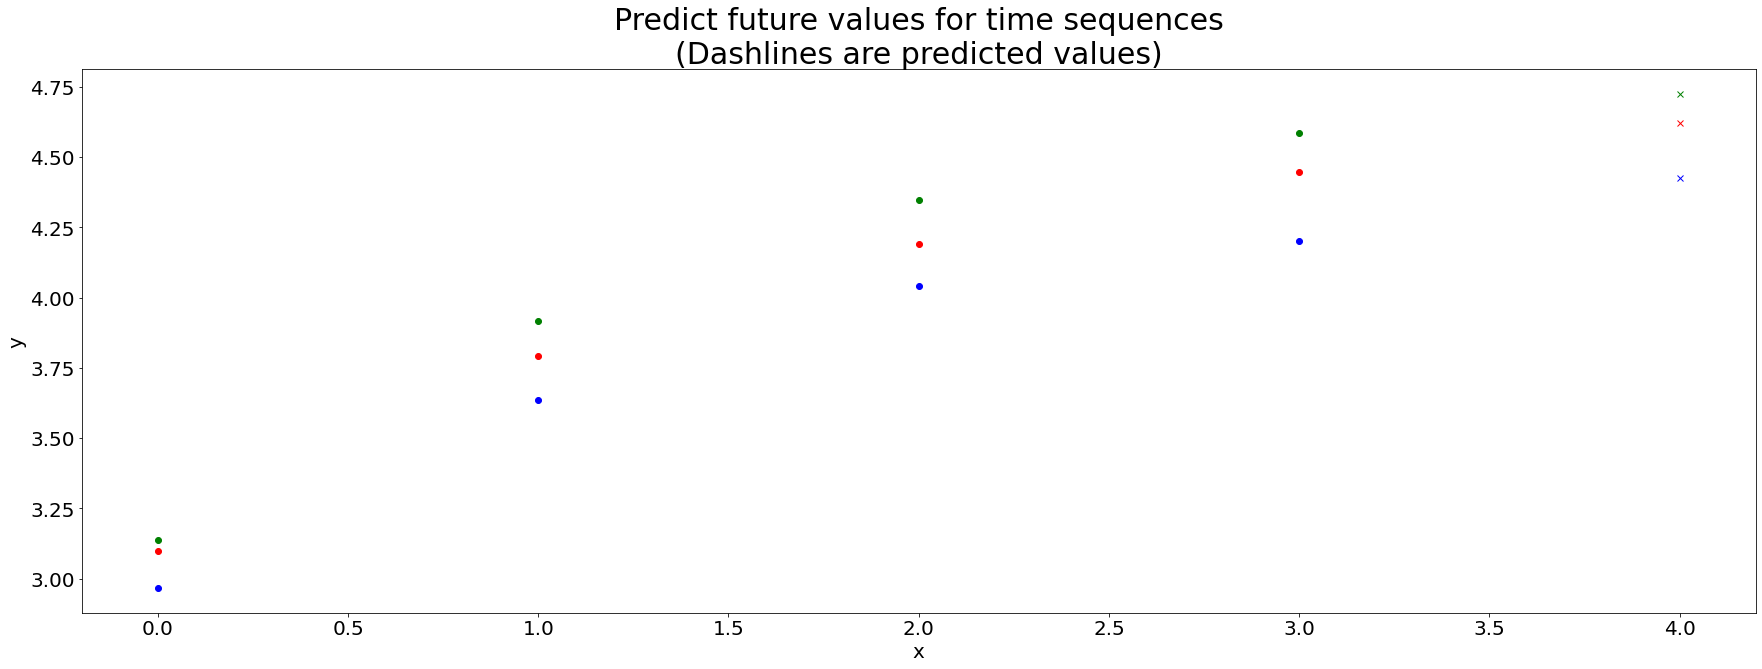

STEP:  1
loss: 0.8604853092280598
loss: 0.8421381638146126
loss: 0.8248325241072655
loss: 0.8081372708684145
loss: 0.7916587571038739
loss: 0.7750065213005181
loss: 0.7577516648317277
loss: 0.7393641600607821
loss: 0.7190997050043586
loss: 0.6957634605154804
loss: 0.667150943322609
loss: 0.6286328791002403
loss: 0.5713200494716832
loss: 0.5151083225461247
loss: 0.5028260392267145
loss: 0.4951205912177548
loss: 0.4856711814140645
loss: 0.47382261023259864
loss: 0.4597530712130526
loss: 0.4416055619220464
test loss: 0.7855986585370386


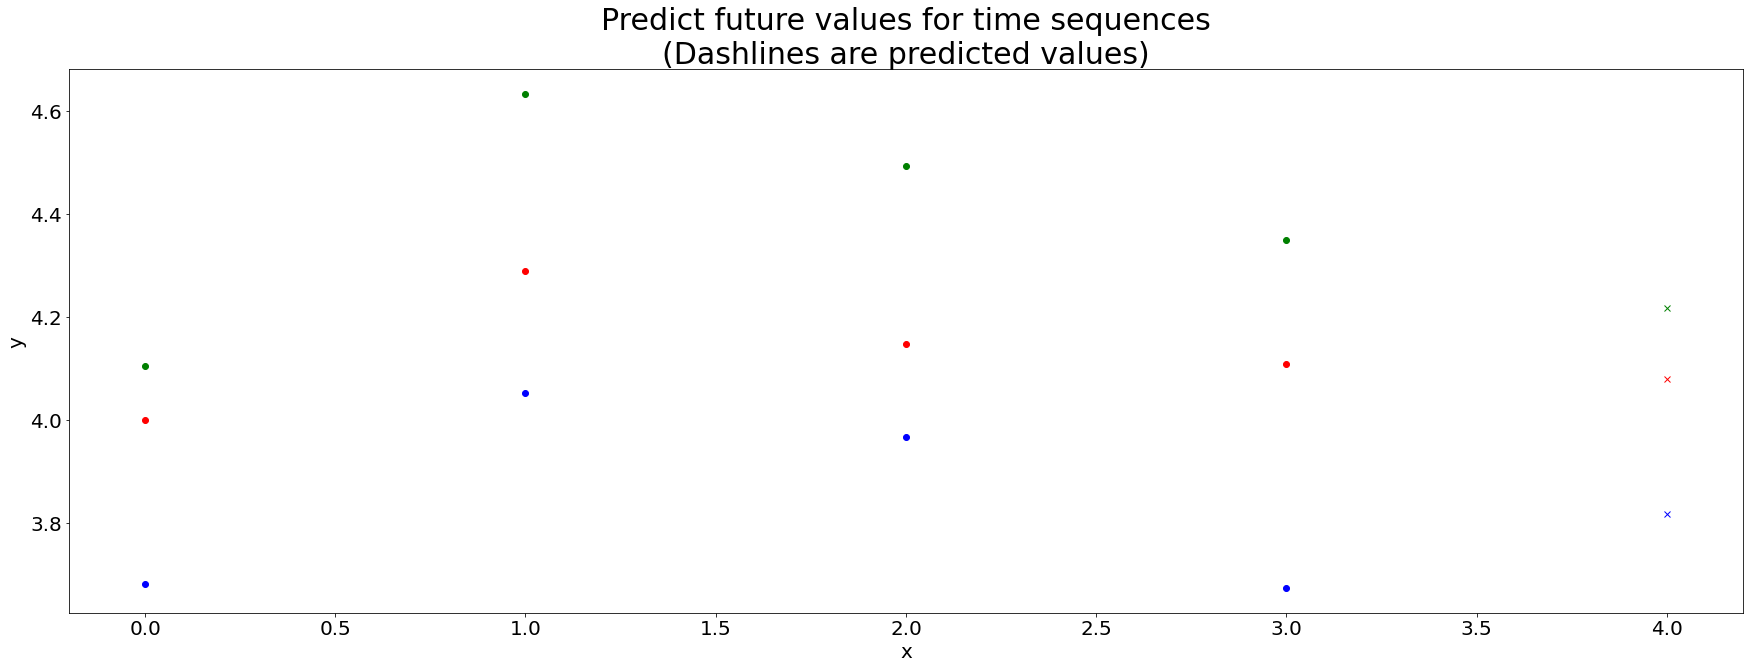

STEP:  2
loss: 0.41937848991384286
loss: 0.3956447673643675
loss: 0.3732325924014181
loss: 0.35319452739072593
loss: 0.334187729079115
loss: 0.31519989614659666
loss: 0.3031512268795627
loss: 0.2947924941569431
loss: 0.28908754462941955
loss: 0.2857762710726378
loss: 0.283389087543179
loss: 0.281542541087294
loss: 0.2800181463442421
loss: 0.2787209877694563
loss: 0.27756558331480236
loss: 0.2764705510592372
loss: 0.27538431852863776
loss: 0.27433619421199584
loss: 0.2733342937846536
loss: 0.2724772145558385
test loss: 0.27422406610801014


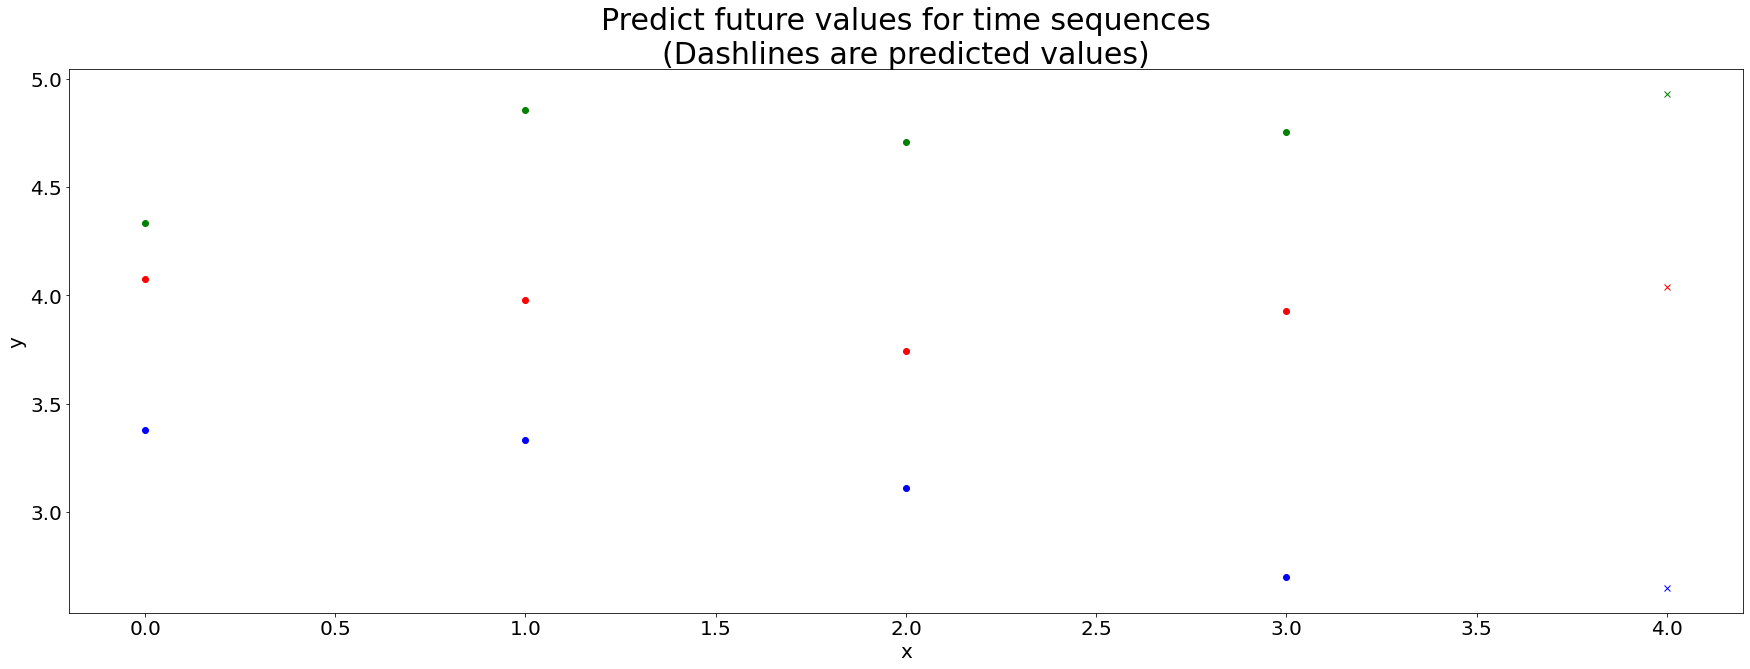

STEP:  3
loss: 0.2716135830314964
loss: 0.2707609003451246
loss: 0.2698684448921647
loss: 0.26867420383562657
loss: 0.2672867740862503
loss: 0.2663147482906866
loss: 0.26539471851084634
loss: 0.2647151510509124
loss: 0.26400273243595057
loss: 0.2634850675404595
loss: 0.26301983668944606
loss: 0.262572397378022
loss: 0.26214736606805106
loss: 0.2617397864187645
loss: 0.26136101568072917
loss: 0.2610072688154231
loss: 0.2606809179145446
loss: 0.2603744867611974
loss: 0.26009089592056234
loss: 0.2598247915788598
test loss: 0.22780979379015875


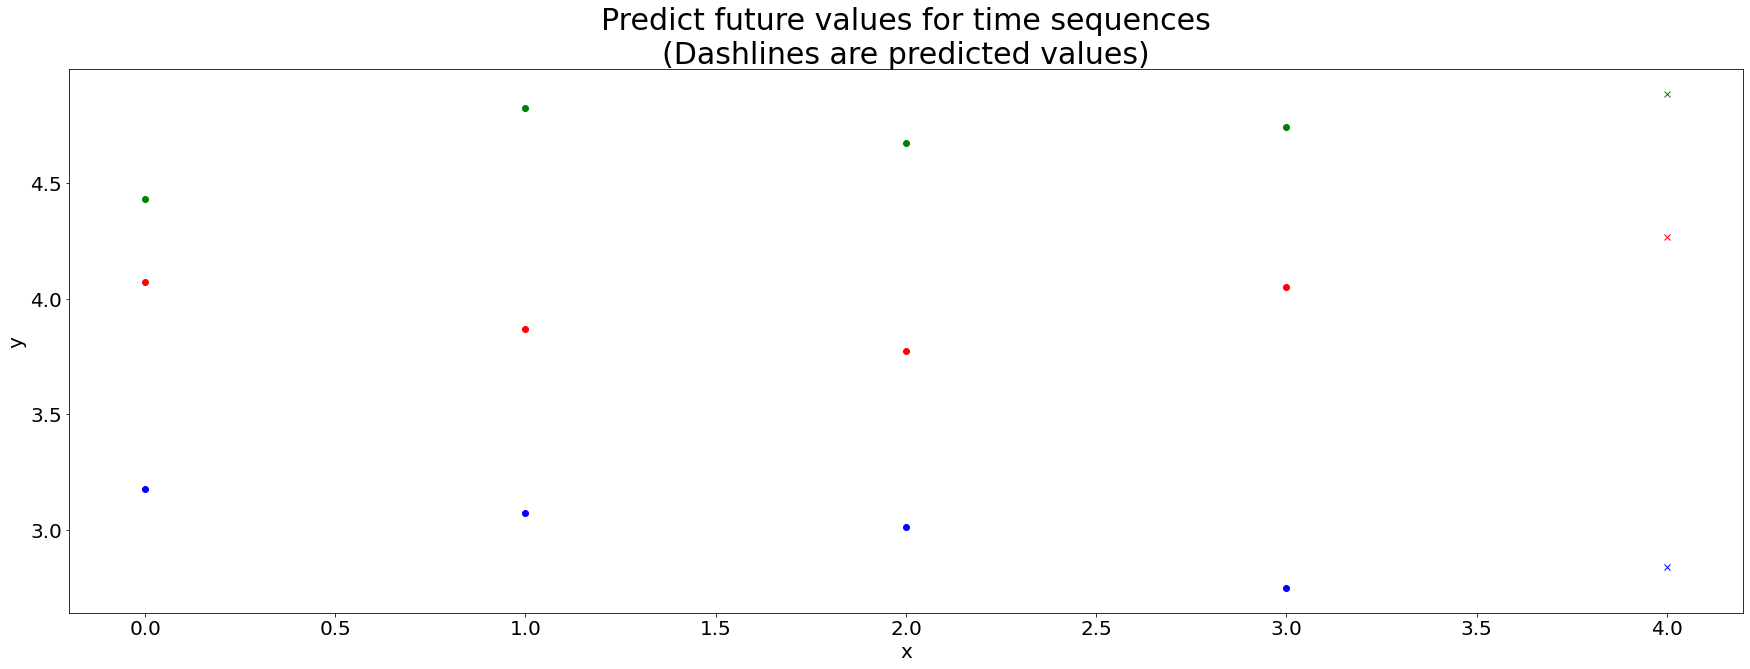

STEP:  4
loss: 0.25957342689846646
loss: 0.25934171616986396
loss: 0.259120586719967
loss: 0.2589225898741236
loss: 0.25874012731123636
loss: 0.2585750046556481
loss: 0.2584272297575153
loss: 0.2582921793596121
loss: 0.25817247509599184
loss: 0.25806162639068253
loss: 0.2579620381651878
loss: 0.2578677140357181
loss: 0.25778089346079164
loss: 0.25769680742473555
loss: 0.2576172971985928
loss: 0.25753887047020496
loss: 0.2574627133287814
loss: 0.25738644800400695
loss: 0.257310480038534
loss: 0.2572334332503614
test loss: 0.25345117809733264


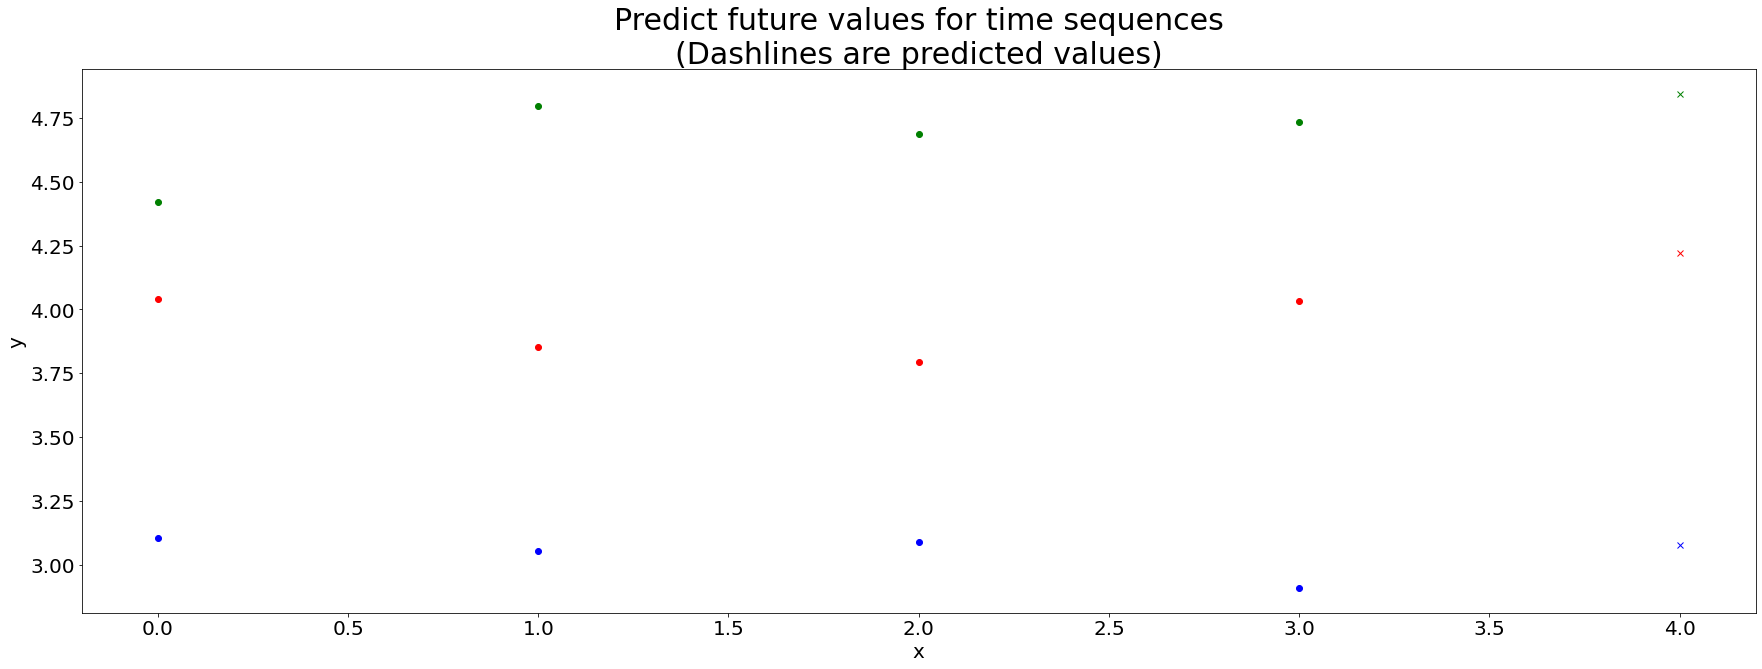

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for input_t in input.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--steps', type=int, default=15, help='steps to run')
#    opt = parser.parse_args()
    STEPS = 5
    # set random seed to 0
    np.random.seed(0)
    torch.manual_seed(0)
    # load data and make training set
    data = torch.load('traindata_noten.pt')
    input = torch.from_numpy(data[3:, :-1])
    target = torch.from_numpy(data[3:, 1:])
    test_input = torch.from_numpy(data[:3, :-1])
    test_target = torch.from_numpy(data[:3, 1:])
    # build the model
    seq = Sequence()
    seq.double()
    criterion = nn.MSELoss()
    # use LBFGS as optimizer since we can load the whole data to train
    optimizer = optim.LBFGS(seq.parameters(), lr=0.08)
    #begin to train
#    for i in range(opt.steps):
    for i in range(STEPS):
        print('STEP: ', i)
        def closure():
            optimizer.zero_grad()
            out = seq(input)
            loss = criterion(out, target)
            print('loss:', loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
        # begin to predict, no need to track gradient here
        with torch.no_grad():
            future = 1
            pred = seq(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print('test loss:', loss.item())
            y = pred.detach().numpy()
        # draw the result
        plt.figure(figsize=(30,10))
        plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
        plt.xlabel('x', fontsize=20)
        plt.ylabel('y', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        def draw(yi, color):
            plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color + 'o', linewidth = 2.0)
            plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + 'x', linewidth = 2.0)
        draw(y[0], 'r')
        draw(y[1], 'g')
        draw(y[2], 'b')
        plt.show()
        plt.close()
    # https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch
    torch.save(seq, "modeldata_noten.pt")
    #torch.save(seq.state_dict(), "modelstate_noten.pt")

# zufällige 3 reihen auswählen als "test_data"
# google; "exam mark ai" -> literatur suchen
# ev. model selbst anpassen; anzahl lstm layer, anzahl hidden_states (freiheitsgrade)
# trainieren auf pnote statt fnote

test loss: 0.25345117809733264


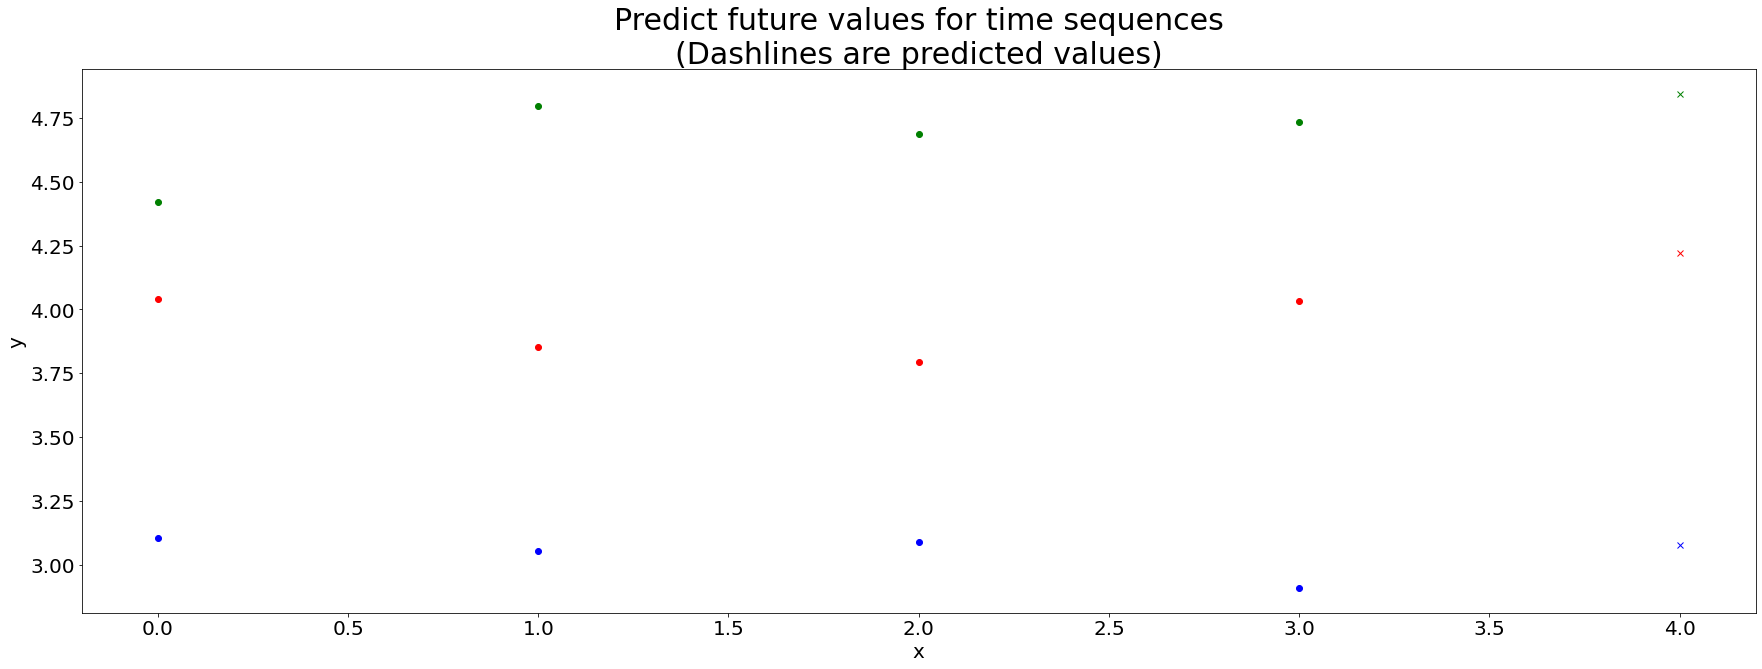

In [3]:
seq = torch.load("modeldata_noten.pt")
#seq.load_state_dict(torch.load("modelstate_noten.pt"))

# begin to predict, no need to track gradient here
with torch.no_grad():
    future = 1
    pred = seq(test_input, future=future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss:', loss.item())
    y = pred.detach().numpy()
# draw the result
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color + 'o', linewidth = 2.0)
    plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + 'x', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
plt.show()
plt.close()
